In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import timm
import torch
import torch.nn as nn

from scipy.spatial import distance
import seaborn as sns

/home/co-dutt1/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def disable_module(module):
    for p in module.parameters():
        p.requires_grad = False
        
def enable_module(module):
    for p in module.parameters():
        p.requires_grad = True


def check_tunable_params(model, verbose=True):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if(verbose):
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.5f}"
    )

    return trainable_params, all_param

def create_mapping(model, vector):
    mapping = {}
    i = 0

    for name_p,p in model.named_parameters():
        if '.attn.' in name_p or 'attention' in name_p:
            mapping[name_p] = vector[i]
            i += 1
        else:
            p.requires_grad = False
            
    return mapping

def sort_dict(dict, descending=False):
    sorted_dict = dict(sorted(dict.items(), key=lambda item: item[1], reverse=descending))
    
    return sorted_dict

def get_modules_from_vector(vector, model):
    trainable_blocks = []
    frozen_blocks = []
    
    trainable_blocks = np.where(np.array(vector) == 1)
    frozen_blocks = np.where(np.array(vector) == 0)
    
    return trainable_blocks, frozen_blocks

def get_model_for_bitfit(model):
    trainable_components = ['bias', 'pooler.dense.bias', 'head'] 

    # Disale all the gradients
    for param in model.parameters():
        param.requires_grad = False 
      
    vector = []

    for name, param in model.named_parameters():
        for component in trainable_components:
            if component in name:
                vector.append(1)
                param.requires_grad = True
                break
    
    return vector

def enable_from_vector(vector, model):
    print("Vector: ", vector)
    
    disable_module(model)
    
    for idx, block in enumerate(model.blocks): 
    
        if(vector[idx] == 1):
            print("Enabling attention in Block {}".format(idx))
            enable_module(block.attn)
        else:
            #print("Disabling attention in Block {}".format(idx))
            disable_module(block.attn)

def create_best_worst_vectors(df, k=10):
    
    best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
    worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

    best_vector = np.array([0]*48)

    for i in range(len(best_df)):
        vector_path = best_df['Vector Path'][i]
        vector = np.load(vector_path)
        print(len(vector))
        best_vector += vector

    worst_vector = np.array([0]*48)

    for i in range(len(worst_df)):
        vector_path = worst_df['Vector Path'][i]
        vector = np.load(vector_path)
        worst_vector += vector

    return best_vector, worst_vector

def tune_blocks_random(model, mask, segment):

    vector = []

    for idx, block in enumerate(model.blocks):

        if(mask is None):
            bit = int(np.random.random(1)[0] > 0.5)
        else:
            bit = mask[idx]

        if(bit == 1):
            print("Enabling {} in Block {}".format(segment, idx))
            if(segment == 'attention'):
                enable_module(block.attn)
            elif(segment == 'layernorm'):
                enable_module(block.norm1)
                enable_module(block.norm2)

            vector.append(1)
        else:
            print("Disabling {} in Block {}".format(segment, idx))
            if(segment == 'attention'):
                disable_module(block.attn)
            elif(segment == 'layernorm'):
                disable_module(block.norm1)
                disable_module(block.norm2)
            
            vector.append(0)
    
    if(mask is not None):
        assert (mask == vector)
        
    return vector

## Attention Tuning (Parameter Level)

### BreastUS Dataset

In [ ]:
dataset = 'breastUS'
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'
csv = base_path + 'vit_base/' + dataset + '/tune_attention_random_vit_base_0.0001.csv'

df = pd.read_csv(csv)
df.head()

In [ ]:
mean_acc = df['Test Acc@1'].mean()
std_acc = df['Test Acc@1'].std()
max_acc = df['Test Acc@1'].max()
min_acc = df['Test Acc@1'].min()
avg_train_percent = df['Train Percent'].mean()
diff = max_acc - min_acc
best_train_percent = df[df['Test Acc@1'] == max_acc]['Train Percent'].values[0]

print("Mean Acc: ", mean_acc)
print("Std Acc: ", std_acc)
print("Max Acc: ", max_acc)
print("Min Acc: ", min_acc)
print("Avg Train Percent: ", avg_train_percent)
print("Best Performance Train Percent: ", best_train_percent)
print("Diff: ", diff)

In [ ]:
k = 10
best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

print(len(best_df), len(worst_df))
worst_df

In [ ]:
best_vector = np.array([0]*12*4)

for i in range(len(best_df)):
    vector_path = best_df['Vector Path'][i]
    vector = np.load(vector_path)
    best_vector += vector

worst_vector = np.array([0]*12*4)

for i in range(len(worst_df)):
    vector_path = worst_df['Vector Path'][i]
    vector = np.load(vector_path)
    worst_vector += vector

best_vector, worst_vector

In [ ]:
best_block_wise_count = {}
block_idx = 0

for i in range(0, len(best_vector), 4):
    
    best_block_wise_count['Block {}'.format(block_idx)] = best_vector[i:i+4]
    block_idx += 1
    
worst_block_wise_count = {}
block_idx = 0

for i in range(0, len(worst_vector), 4):
    
    worst_block_wise_count['Block {}'.format(block_idx)] = worst_vector[i:i+4]
    block_idx += 1

### Which parameters are being activated the most in each block?


In [ ]:
# Create the subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
xtick_labels = [r'$qkv_w$', r'$qkv_b$', r'$proj_w$', r'$proj_b$']

axs = axs.flatten()
xtick_positions = [0,1,2,3]

for i, all_data in enumerate(zip(best_block_wise_count.items(), worst_block_wise_count.items())):
    
    dict1_data = all_data[0]
    dict2_data = all_data[1]
    title = dict1_data[0]
    ax = axs[i]  

    # Create the bar plot
    ax.bar(range(4), dict1_data[1], label='Best Performing')
    ax.bar(range(4), dict2_data[1], label='Worst Performing')
    ax.set_title(title)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.legend()
    #ax.set_xlabel('Parameters')
    #ax.set_ylabel('Selection Count')
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Fitzpatrick Dataset

In [ ]:
dataset = 'fitzpatrick'
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'
csv = base_path + 'vit_base/' + dataset + '/tune_attention_random_vit_base_0.0001.csv'

df = pd.read_csv(csv)
df.head()

In [ ]:
mean_acc = df['Test Acc@1'].mean()
std_acc = df['Test Acc@1'].std()
max_acc = df['Test Acc@1'].max()
min_acc = df['Test Acc@1'].min()
avg_train_percent = df['Train Percent'].mean()
diff = max_acc - min_acc
best_train_percent = df[df['Test Acc@1'] == max_acc]['Train Percent'].values[0]

print("Mean Acc: ", mean_acc)
print("Std Acc: ", std_acc)
print("Max Acc: ", max_acc)
print("Min Acc: ", min_acc)
print("Avg Train Percent: ", avg_train_percent)
print("Best Performance Train Percent: ", best_train_percent)
print("Diff: ", diff)

In [ ]:
k = 10
best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

print(len(best_df), len(worst_df))
worst_df

In [ ]:
best_vector = np.array([0]*12*4)

for i in range(len(best_df)):
    vector_path = best_df['Vector Path'][i]
    vector = np.load(vector_path)
    best_vector += vector

worst_vector = np.array([0]*12*4)

for i in range(len(worst_df)):
    vector_path = worst_df['Vector Path'][i]
    vector = np.load(vector_path)
    worst_vector += vector

best_vector, worst_vector

In [ ]:
best_block_wise_count = {}
block_idx = 0

for i in range(0, len(best_vector), 4):
    
    best_block_wise_count['Block {}'.format(block_idx)] = best_vector[i:i+4]
    block_idx += 1
    
worst_block_wise_count = {}
block_idx = 0

for i in range(0, len(worst_vector), 4):
    
    worst_block_wise_count['Block {}'.format(block_idx)] = worst_vector[i:i+4]
    block_idx += 1

### Which parameters are being activated the most in each block?

In [ ]:
# Create the subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
xtick_labels = [r'$qkv_w$', r'$qkv_b$', r'$proj_w$', r'$proj_b$']

axs = axs.flatten()
xtick_positions = [0,1,2,3]

for i, all_data in enumerate(zip(best_block_wise_count.items(), worst_block_wise_count.items())):
    
    dict1_data = all_data[0]
    dict2_data = all_data[1]
    title = dict1_data[0]
    ax = axs[i]  

    # Create the bar plot
    ax.bar(range(4), dict1_data[1], label='Best Performing')
    ax.bar(range(4), dict2_data[1], label='Worst Performing')
    ax.set_title(title)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.legend()
    #ax.set_xlabel('Parameters')
    #ax.set_ylabel('Selection Count')
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## HAM10000 Dataset

In [ ]:
dataset = 'HAM10000'
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'
csv = base_path + 'vit_base/' + dataset + '/tune_attention_random_vit_base_0.0001.csv'

df = pd.read_csv(csv)
df.head()

In [ ]:
mean_acc = df['Test Acc@1'].mean()
std_acc = df['Test Acc@1'].std()
max_acc = df['Test Acc@1'].max()
min_acc = df['Test Acc@1'].min()
avg_train_percent = df['Train Percent'].mean()
diff = max_acc - min_acc
best_train_percent = df[df['Test Acc@1'] == max_acc]['Train Percent'].values[0]

print("Mean Acc: ", mean_acc)
print("Std Acc: ", std_acc)
print("Max Acc: ", max_acc)
print("Min Acc: ", min_acc)
print("Avg Train Percent: ", avg_train_percent)
print("Best Performance Train Percent: ", best_train_percent)
print("Diff: ", diff)

In [ ]:
k = 10
best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

print(len(best_df), len(worst_df))
worst_df

In [ ]:
best_vector = np.array([0]*12*4)

for i in range(len(best_df)):
    vector_path = best_df['Vector Path'][i]
    vector = np.load(vector_path)
    best_vector += vector

worst_vector = np.array([0]*12*4)

for i in range(len(worst_df)):
    vector_path = worst_df['Vector Path'][i]
    vector = np.load(vector_path)
    worst_vector += vector

best_vector, worst_vector

In [ ]:
best_block_wise_count = {}
block_idx = 0

for i in range(0, len(best_vector), 4):
    
    best_block_wise_count['Block {}'.format(block_idx)] = best_vector[i:i+4]
    block_idx += 1
    
worst_block_wise_count = {}
block_idx = 0

for i in range(0, len(worst_vector), 4):
    
    worst_block_wise_count['Block {}'.format(block_idx)] = worst_vector[i:i+4]
    block_idx += 1

### Which parameters are being activated the most in each block?

In [ ]:
# Create the subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
xtick_labels = [r'$qkv_w$', r'$qkv_b$', r'$proj_w$', r'$proj_b$']

axs = axs.flatten()
xtick_positions = [0,1,2,3]

for i, all_data in enumerate(zip(best_block_wise_count.items(), worst_block_wise_count.items())):
    
    dict1_data = all_data[0]
    dict2_data = all_data[1]
    title = dict1_data[0]
    ax = axs[i]  

    # Create the bar plot
    ax.bar(range(4), dict1_data[1], label='Best Performing')
    ax.bar(range(4), dict2_data[1], label='Worst Performing')
    ax.set_title(title)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.legend()
    #ax.set_xlabel('Parameters')
    #ax.set_ylabel('Selection Count')
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Analysing for all datasets at once

In [2]:
def last_row_to_first(df):
    last_row = df.iloc[-1]
    df = pd.concat([last_row.to_frame().T, df], ignore_index=True)
    df = df.drop(df.index[-1]).reset_index(drop=True)

    return df

def get_best_row(df):
    best_row = df.sort_values(by=['Test Acc@1'], ascending=False).head(1).reset_index(drop=True)
    return best_row

In [6]:
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'

csv_name = 'Fixed_Vectors_tune_attention_params_random_vit_base.csv'
csv_name2 = 'Fixed_Vectors_tune_attention_vit_base.csv'
model = 'vit_base'

dataset = 'breastUS'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_breastUS = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_breastUS = df_breastUS.append(best_row, ignore_index=True)
df_breastUS = last_row_to_first(df_breastUS)

dataset = 'fitzpatrick'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_fitzpatrick = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_fitzpatrick = df_fitzpatrick.append(best_row, ignore_index=True)
df_fitzpatrick = last_row_to_first(df_fitzpatrick)

dataset = 'HAM10000'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_ham10k = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_ham10k = df_ham10k.append(best_row, ignore_index=True)
df_ham10k = last_row_to_first(df_ham10k)

dataset = 'smdg'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_smdg = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_smdg = df_smdg.append(best_row, ignore_index=True)
df_smdg = last_row_to_first(df_smdg)

dataset = 'retinopathy'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_retinopathy = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_retinopathy = df_retinopathy.append(best_row, ignore_index=True)
df_retinopathy = last_row_to_first(df_retinopathy)

dataset = 'CIFAR10'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_CIFAR10 = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_CIFAR10 = df_CIFAR10.append(best_row, ignore_index=True)
df_CIFAR10 = last_row_to_first(df_CIFAR10)

dataset = 'CIFAR100'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_CIFAR100 = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_CIFAR100 = df_CIFAR100.append(best_row, ignore_index=True)
df_CIFAR100 = last_row_to_first(df_CIFAR100)

# dataset = 'pneumonia'
# csv = os.path.join(base_path, model, dataset, csv_name)
# csv2 = os.path.join(base_path, model, dataset, csv_name2)
# df_pneumonia = pd.read_csv(csv)
# df2 = pd.read_csv(csv2)
# best_row = get_best_row(df2)
# df_pneumonia = df_pneumonia.append(best_row, ignore_index=True)
# df_pneumonia = last_row_to_first(df_pneumonia)

# dataset_dict = {'breastUS': df_breastUS, 'fitzpatrick': df_fitzpatrick, 'HAM10000': df_ham10k, 'smdg': df_smdg, 'retinopathy': df_retinopathy, 'CIFAR10': df_CIFAR10, 'CIFAR100': df_CIFAR100, 'pneumonia': df_pneumonia}
dataset_dict = {'breastUS': df_breastUS, 'fitzpatrick': df_fitzpatrick, 'HAM10000': df_ham10k, 'smdg': df_smdg, 'retinopathy': df_retinopathy, 'CIFAR10': df_CIFAR10, 'CIFAR100': df_CIFAR100}

/tmp/ipykernel_18302/994109804.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_breastUS = df_breastUS.append(best_row, ignore_index=True)
/tmp/ipykernel_18302/994109804.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fitzpatrick = df_fitzpatrick.append(best_row, ignore_index=True)
/tmp/ipykernel_18302/994109804.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ham10k = df_ham10k.append(best_row, ignore_index=True)
/tmp/ipykernel_18302/994109804.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_smdg = df_smdg.append(best_row, ignore_index=True)
/tmp/ipykernel_18302/994109804.py:49: FutureWarning: The frame.app

In [8]:
#len(df_breastUS), len(df_fitzpatrick), len(df_ham10k), len(df_retinopathy), len(df_CIFAR10), len(df_CIFAR100), len(df_pneumonia), len(df_smdg)
len(df_breastUS), len(df_fitzpatrick), len(df_ham10k), len(df_retinopathy), len(df_CIFAR10), len(df_CIFAR100), len(df_smdg)

(76, 76, 76, 76, 76, 76, 76)

### How does selective attention fine-tuning (parameter level) compare to full-attention fine-tuning?

In [10]:
best_performance = []
full_attention = []

for dataset in dataset_dict.keys():
    df = dataset_dict[dataset]
    print("Dataset: ", dataset)
    print("Best Performing Method: ", df[df['Test Acc@1'] == df['Test Acc@1'].max()]['Tuning Method'].values[0])
    print("Best Test Acc: ", df['Test Acc@1'].max())
    print("Full Attention FT: ", df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])
    print("Difference: ", df['Test Acc@1'].max() - df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])
    print("\n")
    best_performance.append(df['Test Acc@1'].max())
    full_attention.append(df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])
    

Dataset:  breastUS
Best Performing Method:  tune_attention_params_random
Best Test Acc:  93.50649350649353
Full Attention FT:  89.51077922077921
Difference:  3.995714285714314


Dataset:  fitzpatrick
Best Performing Method:  tune_attention_params_random
Best Test Acc:  84.82198625858838
Full Attention FT:  80.82299812617114
Difference:  3.9989881324172387


Dataset:  HAM10000
Best Performing Method:  tune_attention_params_random
Best Test Acc:  91.8081918081918
Full Attention FT:  90.4095904095904
Difference:  1.3986013986014


Dataset:  smdg
Best Performing Method:  tune_attention_params_random
Best Test Acc:  89.6103896103896
Full Attention FT:  89.12337662337663
Difference:  0.48701298701297446


Dataset:  retinopathy
Best Performing Method:  tune_attention_params_random
Best Test Acc:  77.5626423690205
Full Attention FT:  72.89293849658314
Difference:  4.669703872437353


Dataset:  CIFAR10
Best Performing Method:  tune_attention_params_random
Best Test Acc:  99.08
Full Attention FT

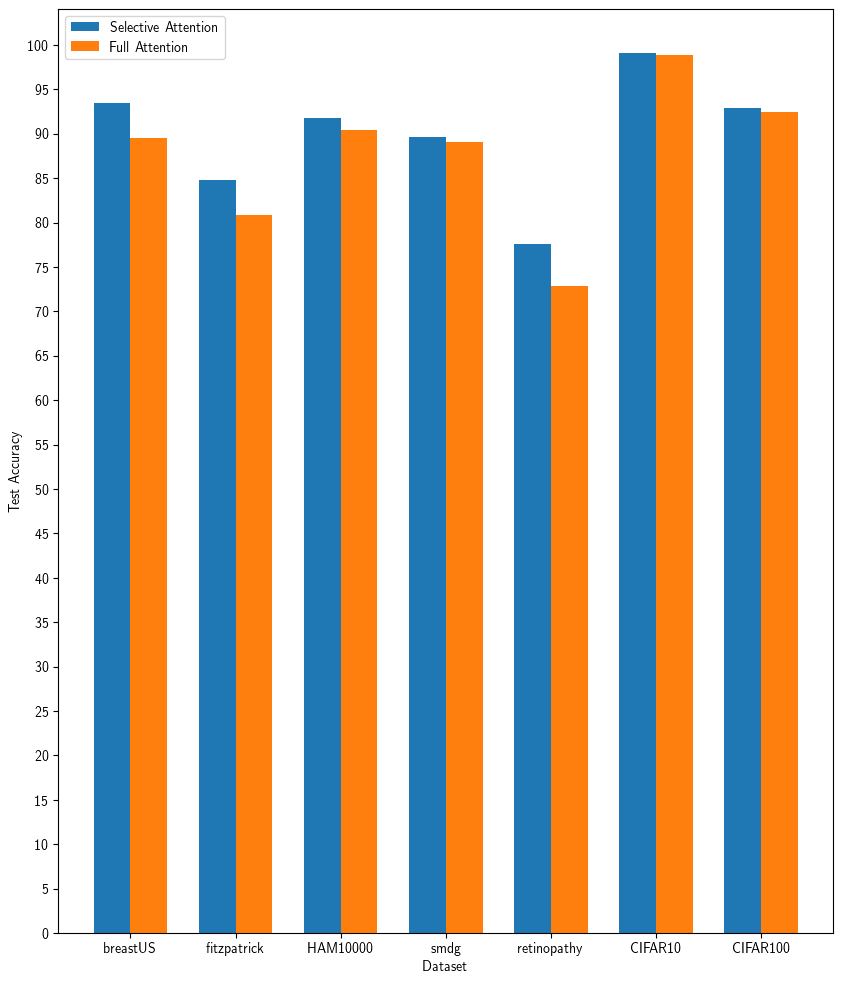

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.35

# Calculate the x-axis positions for the bars
x = np.arange(len(dataset_dict.keys()))
y = np.arange(0, 101, 5)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 12))

# Difference between the two bars
diff = np.array(best_performance) - np.array(full_attention)

# Plot the bars
ax.bar(x - bar_width/2, best_performance, width=bar_width, label='Selective Attention')
ax.bar(x + bar_width/2, full_attention, width=bar_width, label='Full Attention')

# Set the x-axis tick positions and labels
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(list(dataset_dict.keys()))
ax.set_yticklabels(list(range(0, 101, 5)))
ax.set_xlabel('Dataset')
ax.set_ylabel('Test Accuracy')

# Set the legend
ax.legend()

# Display the plot
#plt.show()

#plt.savefig('../plots/selective_vs_full_attention_parameter_level.png')


### Comparing Block Selection b/w best and worst performing vectors

In [19]:
# Sort all the dataframes

k = 10

#all_datasets = [df_breastUS, df_fitzpatrick, df_smdg, df_ham10k, df_retinopathy, df_CIFAR10, df_CIFAR100, df_pneumonia]
all_datasets = [df_breastUS, df_fitzpatrick, df_smdg, df_ham10k, df_retinopathy, df_CIFAR10, df_CIFAR100]

_best = np.array([0]*48)
_worst = np.array([0]*48)

#for df in all_datasets:
for i in range(len(all_datasets)):
    df = all_datasets[i]
    print(i)
    best_vector, worst_vector = create_best_worst_vectors(df)
    _best += best_vector
    _worst += worst_vector

_best

0
48
48
48
48
48
48
48
12


ValueError: operands could not be broadcast together with shapes (48,) (12,) (48,) 

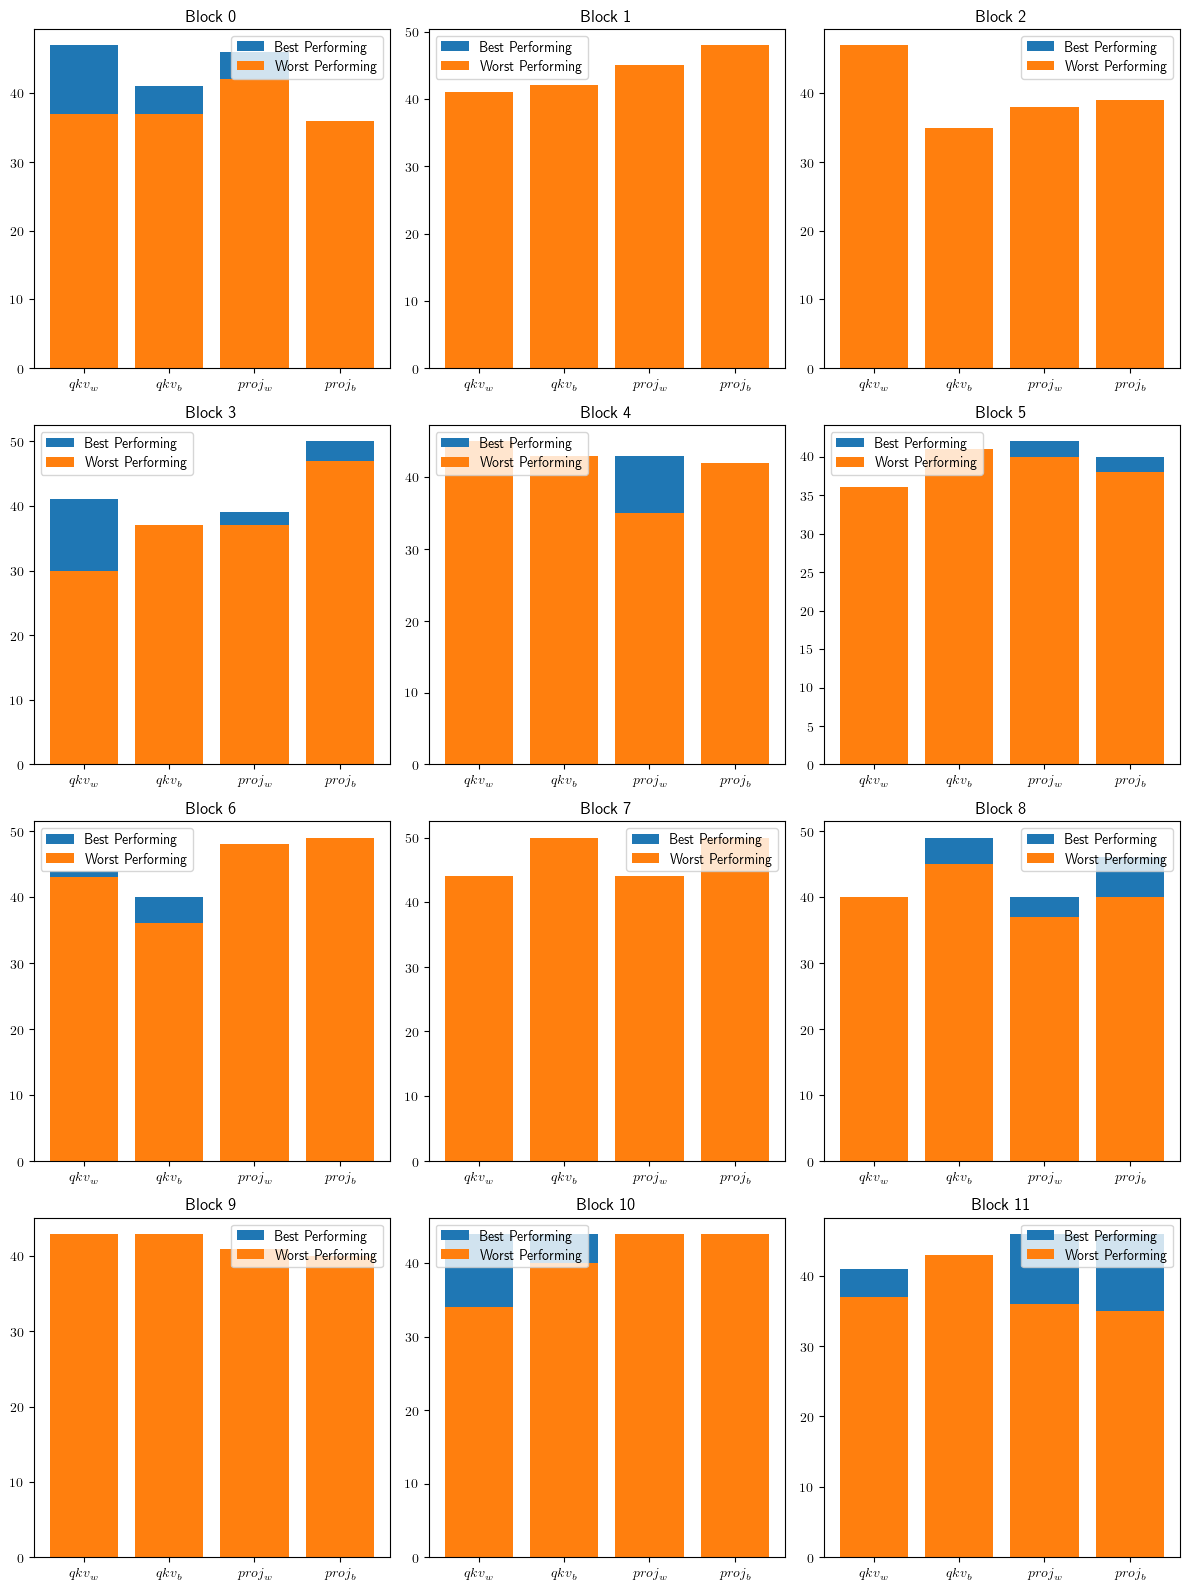

<Figure size 640x480 with 0 Axes>

In [7]:
# Create the subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
xtick_labels = [r'$qkv_w$', r'$qkv_b$', r'$proj_w$', r'$proj_b$']

axs = axs.flatten()
xtick_positions = [0,1,2,3]

for i, all_data in enumerate(zip(result_dict_best.items(), result_dict_worst.items())):
    
    dict1_data = all_data[0]
    dict2_data = all_data[1]
    title = dict1_data[0]
    ax = axs[i]  

    # Create the bar plot
    ax.bar(range(4), dict1_data[1], label='Best Performing')
    ax.bar(range(4), dict2_data[1], label='Worst Performing')
    ax.set_title(title)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.legend()
    #ax.set_xlabel('Parameters')
    #ax.set_ylabel('Selection Count')
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('vit-b_best_worst_parameter_level.png')